# SiPM Calibration

1) Read the histograms of the spectum of the SiPMs with led light and dark current
2) Fit the histograms to two modes: n-gaussians and a poisson+gaussians
3) Plot the main fit parameters and the comparisons between the teo mwthods

In [1]:
from __future__ import print_function

### Revision

In [2]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

29/10/2016   17:14:38


### Dependencies

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import tables
import pandas as pd
import time

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [6]:
pp = %env PYTHONPATH
print(pp)
#from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


### DB  

In [7]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEWMC/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5in =tables.open_file(icdat+ifdat,'a')

In [8]:
# the sipm raw data table (all events)
sipmrd = h5in.root.sipmrd
# number of events, sipms, and w.f.length
nevts,nsipms,nshapes = sipmrd.shape[0],sipmrd.shape[1],sipmrd.shape[2]
print('number of events {}, number of sipms {}, wf length {}'.format(nevts,nsipms,nshapes))

# DB position of the (ordered) SiPMs 
sipmdb = h5in.root.Sensors.DataSiPM
print('DB for a SIPM index {}, {}'.format(0,sipmdb[0]))
h5index_of_sensorid = {sipmdb[i][0] : i for i in range(nsipms) }
i0 = sipmdb[0][0]
print('h5index of sensor id [{}]={}'.format(i0,h5index_of_sensorid[i0]))

def sipm_position_of_sensorid(senid):
    if (not h5index_of_sensorid.has_key(senid)): return [-200.,-200,0.]
    h5index = h5index_of_sensorid[senid]
    pos = sipmdb[h5index][2]
    return pos

senid=1000
pos = sipm_position_of_sensorid(senid)
print('position of sensor id {} = {}'.format(senid,pos))

number of events 1000, number of sipms 1789, wf length 1200
DB for a SIPM index 0, (1000, 1, [-235.0, 45.0, -10000.0], 1.0, 15.5)
h5index of sensor id [1000]=0
position of sensor id 1000 = [  -235.     45. -10000.]


### SiPM calibration data

In [9]:
indir = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/160923/'
irun='2105'
infile = 'sipmCal_singlePulse_R'+irun

In [10]:
# input calibration data: dark current and led
import calib as sc
called = sc.CalData(indir+infile+'_led.txt')
caldark = sc.CalData(indir+infile+'_dark.txt')

loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/160923/sipmCal_singlePulse_R2105_led.txt
number of sensors with data 1792
loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/160923/sipmCal_singlePulse_R2105_dark.txt
number of sensors with data 1792


In [11]:
# create pdf file to put the figures
from matplotlib.backends.backend_pdf import PdfPages
pdf = None

In [12]:
def position_of_indexes(indexes):
    senids = map(sc.sipm_sensorid_of_index,indexes)
    pos = map(sipm_position_of_sensorid,senids)
    return np.array(pos)

In [13]:
# take the reference values
xbins = called.xbins
indexes = called.indexes
positions = position_of_indexes(indexes)

## Calibration

### calibration to ngaussians

In [14]:
# chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
zpss = zip(indexes,pss)

fitting data...
fitting data...
fitting data...
fitting data...
fitting data...


In [15]:
# store the data into pandas
pan = sc.cal_fit_ngauss_panda(indexes, chi2, pss)

### calibration with poisson and n-gaussian

In [16]:
# chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
gchi2,gpss = sc.cal_fit_poissongauss(called,indexes,ngauss=7)
zgpss = zip(indexes,gpss)

fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...


In [17]:
# store the data into pandas
gpan = sc.cal_fit_poissongauss_panda(indexes, gchi2, gpss)

### plots the comparison between the fits 

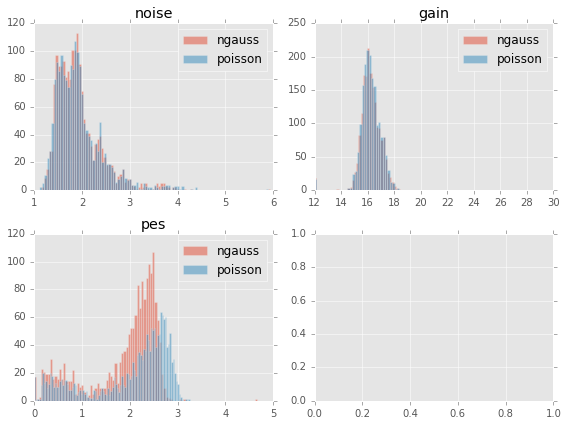

In [18]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_compare_fits.pdf')
labels = ['noise', 'gain', 'pes']
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, label in enumerate(labels):
    ax = plt.subplot(2, 2, i+1)
    cc = ax.hist(pan[label], 100, alpha=0.5, label='ngauss')
    cc = ax.hist(gpan[label], 100, alpha=0.5, label='poisson')
    ax.legend(loc='upper right')
    ax.set_title(label)
fig.tight_layout()
if (pdf): pdf.savefig(fig)
plt.show()
if (pdf): pdf.close()

### Plotting parameters

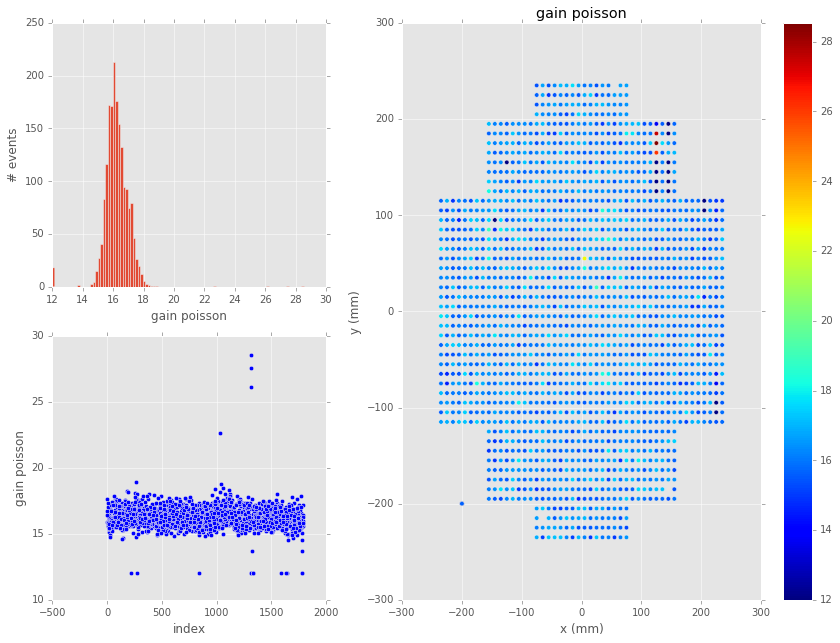

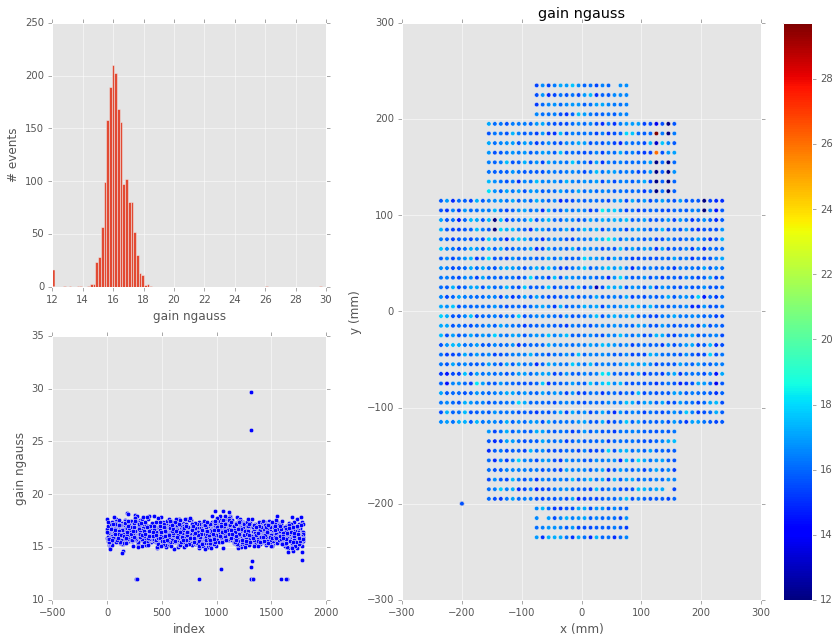

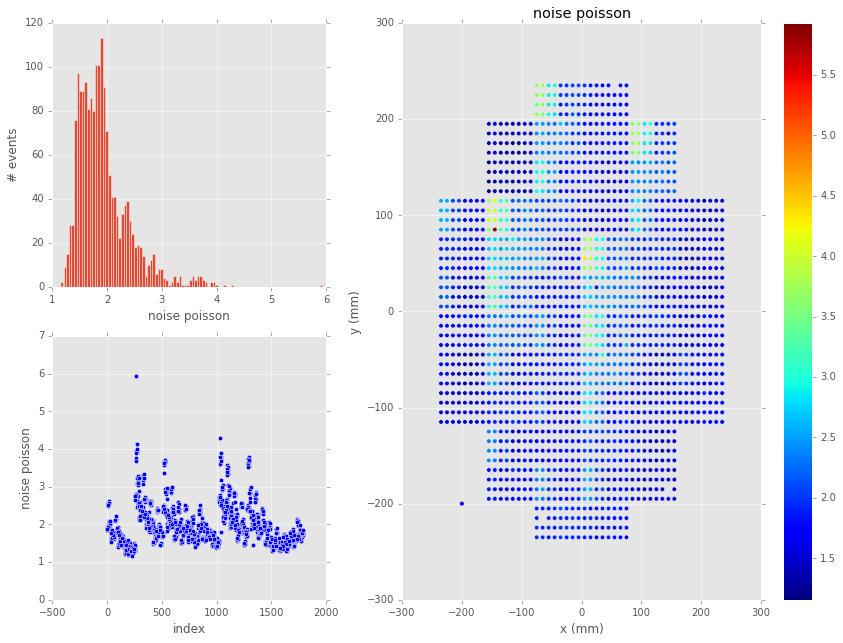

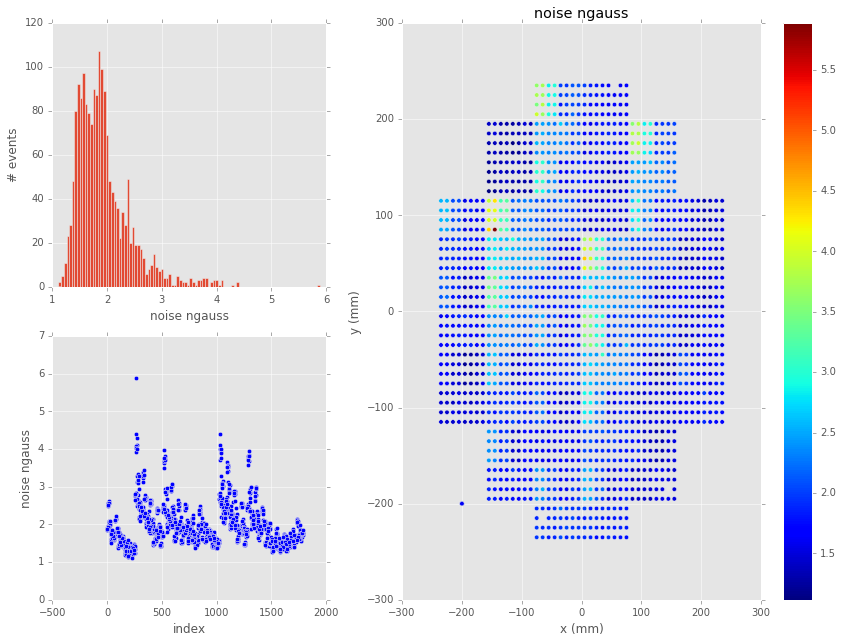

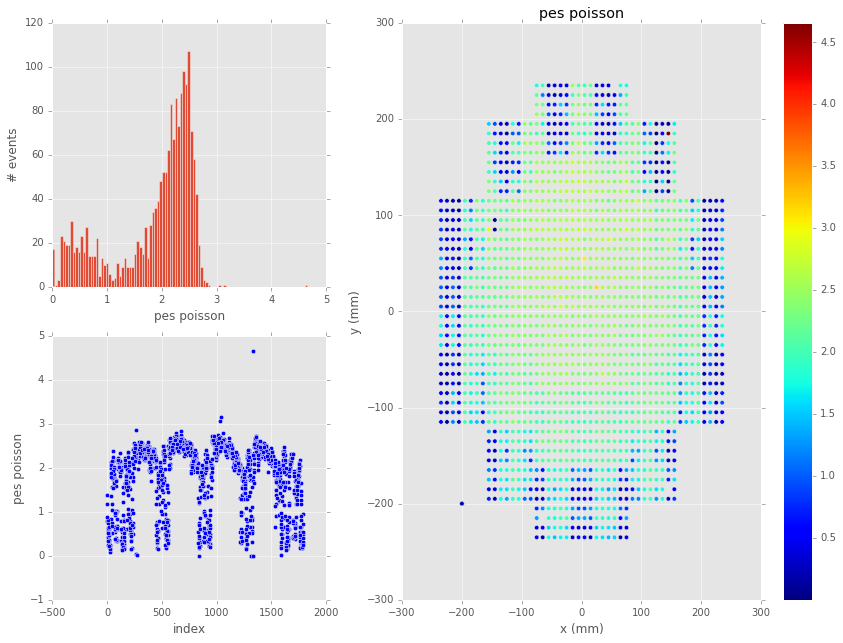

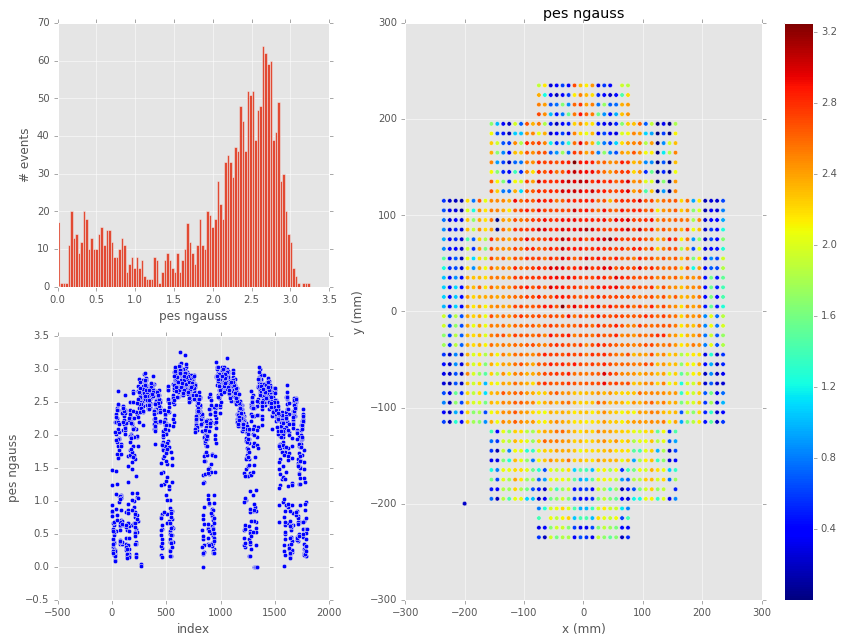

In [19]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_compare_figs.pdf')
labels = ['gain', 'noise', 'pes']
for label in labels:
    fig = sc.polo_pars(pan['indexes'], pan[label], positions, label=label+' poisson')
    if (pdf): pdf.savefig(fig)
    fig = sc.polo_pars(gpan['indexes'], gpan[label], positions, label=label+' ngauss')
    if (pdf): pdf.savefig(fig)
pdf.close()

That's all folks!